# Spatial joins

Goals of this notebook:

- Based on the `countries` and `cities` dataframes, determine for each city the country in which it is located.
- To solve this problem, we will use the the concept of a 'spatial join' operation: combining information of geospatial datasets based on their spatial relationship.

In [2]:
%matplotlib inline

import pandas as pd
import geopandas
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10

In [3]:
countries = geopandas.read_file("zip://./data/ne_110m_admin_0_countries.zip")
cities = geopandas.read_file("zip://./data/ne_110m_populated_places.zip")
rivers = geopandas.read_file("zip://./data/ne_50m_rivers_lake_centerlines.zip")

In [6]:
countries.crs, cities.crs, rivers.crs

({'init': 'epsg:4326'}, {'init': 'epsg:4326'}, {'init': 'epsg:4326'})

## Recap - joining dataframes

Pandas provides functionality to join or merge dataframes in different ways, see https://chrisalbon.com/python/data_wrangling/pandas_join_merge_dataframe/ for an overview and https://pandas.pydata.org/pandas-docs/stable/merging.html for the full documentation.

To illustrate the concept of joining the information of two dataframes with pandas, let's take a small subset of our `cities` and `countries` datasets: 

In [7]:
cities2 = cities[cities['name'].isin(['Bern', 'Brussels', 'London', 'Paris'])].copy()
cities2['iso_a3'] = ['CHE', 'BEL', 'GBR', 'FRA']

In [8]:
cities2

,name,geometry,iso_a3
26,Bern,POINT (7.466975462482424 46.91668275866772),CHE
170,Brussels,POINT (4.33137074969045 50.83526293533032),BEL
219,London,POINT (-0.1186677024759319 51.5019405883275),GBR
235,Paris,POINT (2.33138946713035 48.86863878981461),FRA


In [9]:
countries2 = countries[['iso_a3', 'name', 'continent']]
countries2.head()

,iso_a3,name,continent
0,AFG,Afghanistan,Asia
1,AGO,Angola,Africa
2,ALB,Albania,Europe
3,ARE,United Arab Emirates,Asia
4,ARG,Argentina,South America


We added a 'iso_a3' column to the `cities` dataset, indicating a code of the country of the city. This country code is also present in the `countries` dataset, which allows us to merge those two dataframes based on the common column.

Joining the `cities` dataframe with `countries` will transfer extra information about the countries (the full name, the continent) to the `cities` dataframe, based on a common key:

In [10]:
cities2.merge(countries2, on='iso_a3')

,name_x,geometry,iso_a3,name_y,continent
0,Bern,POINT (7.466975462482424 46.91668275866772),CHE,Switzerland,Europe
1,Brussels,POINT (4.33137074969045 50.83526293533032),BEL,Belgium,Europe
2,London,POINT (-0.1186677024759319 51.5019405883275),GBR,United Kingdom,Europe
3,Paris,POINT (2.33138946713035 48.86863878981461),FRA,France,Europe


**But**, for this illustrative example, we added the common column manually, it is not present in the original dataset. However, we can still know how to join those two datasets based on their spatial coordinates.

## Recap - spatial relationships between objects

In the previous notebook [02-spatial-relationships.ipynb](./02-spatial-relationships-operations.ipynb), we have seen the notion of spatial relationships between geometry objects: within, contains, intersects, ...

In this case, we know that each of the cities is located *within* one of the countries, or the other way around that each country can *contain* multiple cities.

We can test such relationships using the methods we have seen in the previous notebook:

In [11]:
france = countries.loc[countries['name'] == 'France', 'geometry'].squeeze()

In [12]:
cities.within(france)

0      False
1      False
2      False
3      False
4      False
       ...  
238    False
239    False
240    False
241    False
242    False
Length: 243, dtype: bool

The above gives us a boolean series, indicating for each point in our `cities` dataframe whether it is located within the area of France or not.  
Because this is a boolean series as result, we can use it to filter the original dataframe to only show those cities that are actually within France:

In [13]:
cities[cities.within(france)]

,name,geometry
10,Monaco,POINT (7.406913173465057 43.73964568785249)
13,Andorra,POINT (1.51648596050552 42.5000014435459)
186,Geneva,POINT (6.140028034091699 46.21000754707626)
235,Paris,POINT (2.33138946713035 48.86863878981461)


In [16]:
usa = countries[countries['name'].str.contains('America',case=False,na=False)]
usa

,iso_a3,name,continent,pop_est,gdp_md_est,geometry
168,USA,United States of America,North America,326625791.0,18560000.0,"(POLYGON ((-122.84 49.00000000000014, -120 49...."


In [20]:
cities.shape

(243, 2)

We could now repeat the above analysis for each of the countries, and add a column to the `cities` dataframe indicating this country. However, that would be tedious to do manually, and is also exactly what the spatial join operation provides us.

*(note: the above result is incorrect, but this is just because of the coarse-ness of the countries dataset)*

## Spatial join operation

<div class="alert alert-info" style="font-size:120%">
<b>SPATIAL JOIN</b> = *transferring attributes from one layer to another based on their spatial relationship* <br><br>


Different parts of this operations:

<ul>
  <li>The GeoDataFrame to which we want add information</li>
  <li>The GeoDataFrame that contains the information we want to add </li>
  <li>The spatial relationship we want to use to match both datasets ('intersects', 'contains', 'within')</li>
  <li>The type of join: left or inner join</li>
</ul>

</div>

In this case, we want to join the `cities` dataframe with the information of the `countries` dataframe, based on the spatial relationship between both datasets.

We use the [`geopandas.sjoin`](http://geopandas.readthedocs.io/en/latest/reference/geopandas.sjoin.html) function:

In [21]:
joined = geopandas.sjoin(cities, countries, op='within', how='left')

In [22]:
joined

,name_left,geometry,index_right,iso_a3,name_right,continent,pop_est,gdp_md_est
0,Vatican City,POINT (12.45338654497177 41.90328217996012),79.0,ITA,Italy,Europe,6.213780e+07,2221000.0
1,San Marino,POINT (12.44177015780014 43.936095834768),79.0,ITA,Italy,Europe,6.213780e+07,2221000.0
2,Vaduz,POINT (9.516669472907267 47.13372377429357),9.0,AUT,Austria,Europe,8.754413e+06,416600.0
3,Lobamba,POINT (31.19999710971274 -26.46666746135247),152.0,SWZ,Swaziland,Africa,1.467152e+06,11060.0
4,Luxembourg,POINT (6.130002806227083 49.61166037912108),97.0,LUX,Luxembourg,Europe,5.941300e+05,58740.0
...,...,...,...,...,...,...,...,...
238,Rio de Janeiro,POINT (-43.22696665284366 -22.92307731561596),22.0,BRA,Brazil,South America,2.073534e+08,3081000.0
239,São Paulo,POINT (-46.62696583905523 -23.55673372837896),22.0,BRA,Brazil,South America,2.073534e+08,3081000.0
240,Sydney,POINT (151.1832339501475 -33.91806510862875),8.0,AUS,Australia,Oceania,2.323241e+07,1189000.0
241,Singapore,POINT (103.853874819099 1.294979325105942),111.0,MYS,Malaysia,Asia,3.138199e+07,863000.0


In [23]:
joined['continent'].value_counts()

Asia             59
Africa           57
Europe           46
North America    26
South America    14
Oceania           8
Name: continent, dtype: int64

In [24]:
joined[joined.continent.str.contains('North',
                                    case=False,na=False)]

,name_left,geometry,index_right,iso_a3,name_right,continent,pop_est,gdp_md_est
14,Port-of-Spain,POINT (-61.51703088544974 10.65199708957726),160.0,TTO,Trinidad and Tobago,North America,1218208.0,43570.0
54,Tegucigalpa,POINT (-87.21947519794151 14.1039907590764),68.0,HND,Honduras,North America,9038741.0,43190.0
57,Port-au-Prince,POINT (-72.33798044690553 18.54297045473237),70.0,HTI,Haiti,North America,10646714.0,19340.0
63,Managua,POINT (-86.27043751890119 12.15496243875612),116.0,NIC,Nicaragua,North America,6025951.0,33550.0
71,Panama City,POINT (-79.53498301041077 8.969963049094872),123.0,PAN,Panama,North America,3753142.0,93120.0
...,...,...,...,...,...,...,...,...
209,Toronto,POINT (-79.42196665298843 43.70192573640844),27.0,CAN,Canada,North America,35623680.0,1674000.0
216,Los Angeles,POINT (-118.1819263699404 33.99192410876543),168.0,USA,United States of America,North America,326625791.0,18560000.0
217,"Washington, D.C.",POINT (-77.01136443943716 38.90149523508705),168.0,USA,United States of America,North America,326625791.0,18560000.0
218,New York,POINT (-73.98196278740681 40.75192492259464),168.0,USA,United States of America,North America,326625791.0,18560000.0


## Lets's practice!

We will again use the Paris datasets to do some exercises. Let's start importing them again:

In [25]:
districts = geopandas.read_file("data/paris_districts_utm.geojson")
stations = geopandas.read_file("data/paris_sharing_bike_stations_utm.geojson")

<div class="alert alert-success">
 <b>EXERCISE: Make a plot of the density of bike stations by district</b>
 <p>
 <ul>
  <li>Determine for each bike station in which district it is located (using a spatial join!). Call the result `joined`.</li>
  <li>Based on this result, calculate the number of bike stations in each district (e.g. using `groupby` method; you can use the `size` size method to know the size of each group).
    <ul>
      <li>Make sure the result is a DataFrame called `counts` with the columns 'district_name' and 'n_bike_stations'.</li>
      <li>To go from a Series to a DataFrame, you can use the `reset_index` or `to_frame` method (both have a `name` keyword to specify a column name for the original Series values.
    </ul>   
   </li>
  <li>Add those counts to the original `districts` dataframe, creating a new `districts2` dataframe (tip: this is a merge operation).</li>
  <li>Calculate a new column 'n_bike_stations_by_area'.</li>
  <li>Make a plot showing the density in bike stations of the districts.</li>  
 </ul> 
 </p>
 
</div>

In [27]:
joined = geopandas.sjoin(stations, districts,
                op='within',how='left')

In [28]:
geopandas.sjoin?

Signature: geopandas.sjoin(left_df, right_df, how='inner', op='intersects', lsuffix='left', rsuffix='right')
Docstring:
Spatial join of two GeoDataFrames.

Parameters
----------
left_df, right_df : GeoDataFrames
how : string, default 'inner'
    The type of join:

    * 'left': use keys from left_df; retain only left_df geometry column
    * 'right': use keys from right_df; retain only right_df geometry column
    * 'inner': use intersection of keys from both dfs; retain only
      left_df geometry column
op : string, default 'intersection'
    Binary predicate, one of {'intersects', 'contains', 'within'}.
    See http://toblerity.org/shapely/manual.html#binary-predicates.
lsuffix : string, default 'left'
    Suffix to apply to overlapping column names (left GeoDataFrame).
rsuffix : string, default 'right'
    Suffix to apply to overlapping column names (right GeoDataFrame).
File:      /anaconda3/envs/geopandas/lib/python3.6/site-packages/geopandas/tools/sjoin.py
Type:      function


In [29]:
joined.head()

,name,bike_stands,available_bikes,geometry,index_right,id,district_name,population
0,14002 - RASPAIL QUINET,44,4,POINT (450804.448740735 5409797.268203795),52.0,53.0,Montparnasse,18570.0
1,20503 - COURS DE VINCENNES PYRÉNÉES,21,3,POINT (456414.3523840572 5410698.461014213),79.0,80.0,Charonne,62901.0
2,20011 - PYRÉNÉES-DAGORNO,21,0,POINT (456366.9088116739 5411563.319737446),79.0,80.0,Charonne,62901.0
3,31008 - VINCENNES (MONTREUIL),56,0,POINT (458730.7071295079 5411789.995450836),NaN,NaN,NaN,NaN
4,43006 - MINIMES (VINCENNES),28,27,POINT (458234.9299846432 5409991.066579348),NaN,NaN,NaN,NaN


In [30]:
counts = joined.groupby('district_name')['bike_stands'].size()

In [32]:
dfcounts = counts.to_frame(name='n_bike_stations')
dfcounts

,n_bike_stations
district_name,
Amérique,17
Archives,4
Arsenal,7
Arts-et-Metiers,4
Auteuil,21
...,...
St-Germain-l'Auxerrois,4
Ternes,18
Val-de-Grace,7


In [33]:
dfcounts['district_name'] = dfcounts.index

In [34]:
districts.head()

,id,district_name,population,geometry
0,1,St-Germain-l'Auxerrois,1672,"POLYGON ((451922.1333912524 5411438.484355546,..."
1,2,Halles,8984,"POLYGON ((452278.4194036503 5412160.89282334, ..."
2,3,Palais-Royal,3195,"POLYGON ((451553.8057660239 5412340.522224233,..."
3,4,Place-Vendôme,3044,"POLYGON ((451004.907944323 5412654.094913081, ..."
4,5,Gaillon,1345,"POLYGON ((451328.7522686935 5412991.278156867,..."


In [36]:
districts2 = pd.merge(dfcounts, districts, on='district_name')

/anaconda3/envs/geopandas/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: FutureWarning: 'district_name' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [37]:
districts2.head()

,n_bike_stations,district_name,id,population,geometry
0,17,Amérique,75,55365,"POLYGON ((456698.7712366731 5414305.564307321,..."
1,4,Archives,11,8609,"POLYGON ((453675.9675547979 5411621.632537843,..."
2,7,Arsenal,15,9474,"POLYGON ((453678.2733823431 5411610.865300431,..."
3,4,Arts-et-Metiers,9,9560,"POLYGON ((453078.1086852358 5412667.110192569,..."
4,21,Auteuil,61,67967,"POLYGON ((444930.4989573474 5411923.067114253,..."


In [40]:
type(districts2)

pandas.core.frame.DataFrame

In [42]:
districts2 = geopandas.GeoDataFrame(districts2)

In [43]:
districts2['bike_stations_by_area'] = districts2['n_bike_stations'] / (
        districts2['geometry'].area)

In [44]:
districts2

,n_bike_stations,district_name,id,population,geometry,bike_stations_by_area
0,17,Amérique,75,55365,"POLYGON ((456698.7712366731 5414305.564307321,...",0.000009
1,4,Archives,11,8609,"POLYGON ((453675.9675547979 5411621.632537843,...",0.000011
2,7,Arsenal,15,9474,"POLYGON ((453678.2733823431 5411610.865300431,...",0.000014
3,4,Arts-et-Metiers,9,9560,"POLYGON ((453078.1086852358 5412667.110192569,...",0.000013
4,21,Auteuil,61,67967,"POLYGON ((444930.4989573474 5411923.067114253,...",0.000003
...,...,...,...,...,...,...
75,4,St-Germain-l'Auxerrois,1,1672,"POLYGON ((451922.1333912524 5411438.484355546,...",0.000005
76,18,Ternes,65,39137,"POLYGON ((448307.4246711035 5413664.062483684,...",0.000012
77,7,Val-de-Grace,19,19492,"POLYGON ((451978.8994842967 5410440.076632559,...",0.000010
78,14,Villette,73,53650,"POLYGON ((453844.6374796607 5414106.7643801, 4...",0.000011


Text(0.5, 1.0, 'Bike Station Density by District')

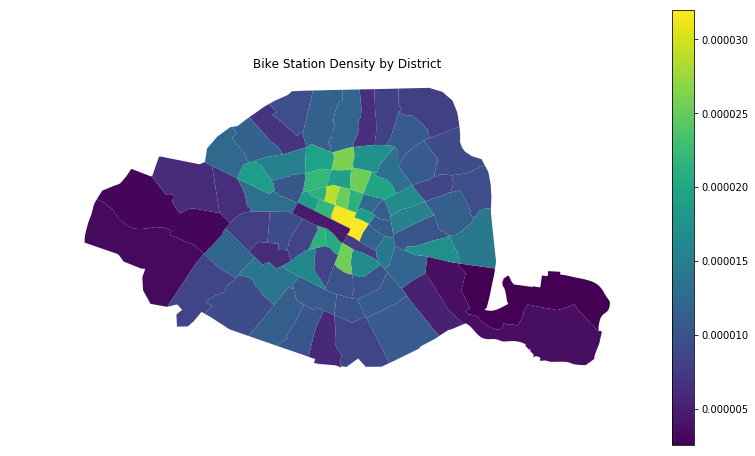

In [52]:
ax = districts2.plot(column='bike_stations_by_area',
                    legend=True,figsize=(1.618*8,8))
ax.set_axis_off()
ax.set_title('Bike Station Density by District')

In [ ]:
# %load _solved/solutions/03-spatial-joins14.py

In [ ]:
# %load _solved/solutions/03-spatial-joins15.py

In [ ]:
# %load _solved/solutions/03-spatial-joins16.py

In [ ]:
# %load _solved/solutions/03-spatial-joins17.py

In [ ]:
# %load _solved/solutions/03-spatial-joins18.py

In [ ]:
# %load _solved/solutions/03-spatial-joins19.py

In [ ]:
# %load _solved/solutions/03-spatial-joins20.py

## The overlay operation

In the spatial join operation above, we are not changing the geometries itself. We are not joining geometries, but joining attributes based on a spatial relationship between the geometries. This also means that the geometries need to at least overlap partially.

If you want to create new geometries based on joining (combining) geometries of different dataframes into one new dataframe (eg by taking the intersection of the geometries), you want an **overlay** operation.

In [ ]:
africa = countries[countries['continent'] == 'Africa']

In [ ]:
africa.plot()

In [ ]:
cities['geometry'] = cities.buffer(2)

In [ ]:
geopandas.overlay(africa, cities, how='difference').plot()

<div class="alert alert-info" style="font-size:120%">
<b>REMEMBER</b> <br>

<ul>
  <li>**Spatial join**: transfer attributes from one dataframe to another based on the spatial relationship</li>
  <li>**Spatial overlay**: construct new geometries based on spatial operation between both dataframes (and combining attributes of both dataframes)</li>
</ul>

</div>